# Data Prep and Inspection

Importing Packages

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")

print("Packages successfully imported!")

Packages successfully imported!


Importing the data

In [48]:
data = pd.read_csv("data/data_raw.csv")

print("Data successfully imported!")

Data successfully imported!


### Inspecting Data

In [49]:
data.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied


In [50]:
print(f"The dataset has {data.shape[0]} rows")

The dataset has 350 rows


In [51]:
dupl = data['Customer ID'].value_counts()[data['Customer ID'].value_counts()>1].size
print(f"Duplicates: {dupl}")
# No customer duplicates

Duplicates: 0


Checking missing values

In [52]:
data.isna().sum()

Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64

We will remove the two rows with NA's as there's only two.

In [53]:
data_full = data.dropna()

print(f"The new dataset has {data_full.shape[0]} rows")

The new dataset has 348 rows


Checking for missing data

Inspecting counts and summary stats for cat and numeric vars, respectively

In [54]:
# Selecting numeric columns
numeric_stats = data_full.describe()

# For categorical columns
categorical_columns = data_full.select_dtypes(include=['object', 'category']).columns
categorical_values = {col: data_full[col].value_counts() for col in categorical_columns}

# Display results
print("Numeric Stats:\n", numeric_stats)
print("\nCategorical Values:")
for col, values in categorical_values.items():
    print(f"\n{col}:\n", values)


Numeric Stats:
        Customer ID         Age  Total Spend  Items Purchased  Average Rating  \
count   348.000000  348.000000   348.000000       348.000000      348.000000   
mean    275.887931   33.577586   847.793103        12.632184        4.023563   
std     101.304611    4.878024   361.692375         4.146079        0.579145   
min     101.000000   26.000000   410.800000         7.000000        3.000000   
25%     188.750000   30.000000   505.750000         9.000000        3.500000   
50%     276.500000   32.000000   780.200000        12.000000        4.100000   
75%     363.250000   37.000000  1160.600000        15.000000        4.500000   
max     450.000000   43.000000  1520.100000        21.000000        4.900000   

       Days Since Last Purchase  
count                348.000000  
mean                  26.614943  
std                   13.474750  
min                    9.000000  
25%                   15.000000  
50%                   23.000000  
75%                   38.

Plotting pie charts for the categorical vars

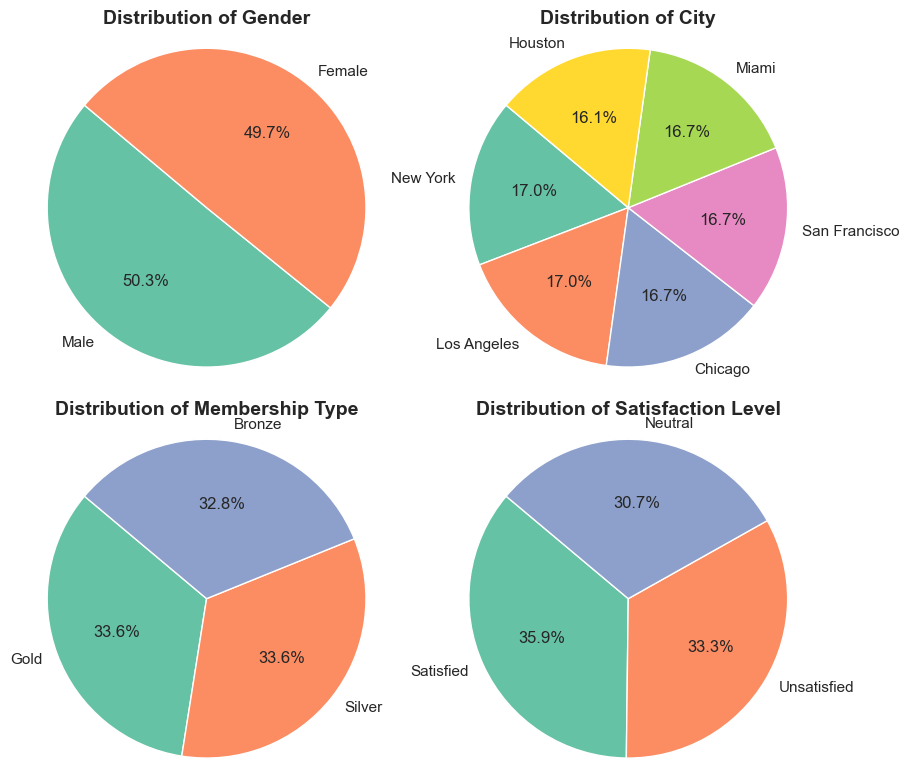

In [55]:
# Create a 2x2 grid for the pie charts
fig, axes = plt.subplots(2, 2, figsize=(9, 8))

# Flatten the axes array for iter
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    # get value counts for the column
    values = data_full[col].value_counts()
    
    # plot pie chart on the corresponding axis
    axes[i].pie(values, labels=values.index, autopct='%1.1f%%', startangle=140, 
                colors=palette[:len(values)])
    
    # setting the title for each subplot
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    
    # equal aspect ratio ensures circle
    axes[i].axis('equal')

# Adjust layout, prevent overlap
plt.tight_layout()

plt.show()

Categorical variables seem to have very equal distributions, we will now inspect the numeric vars

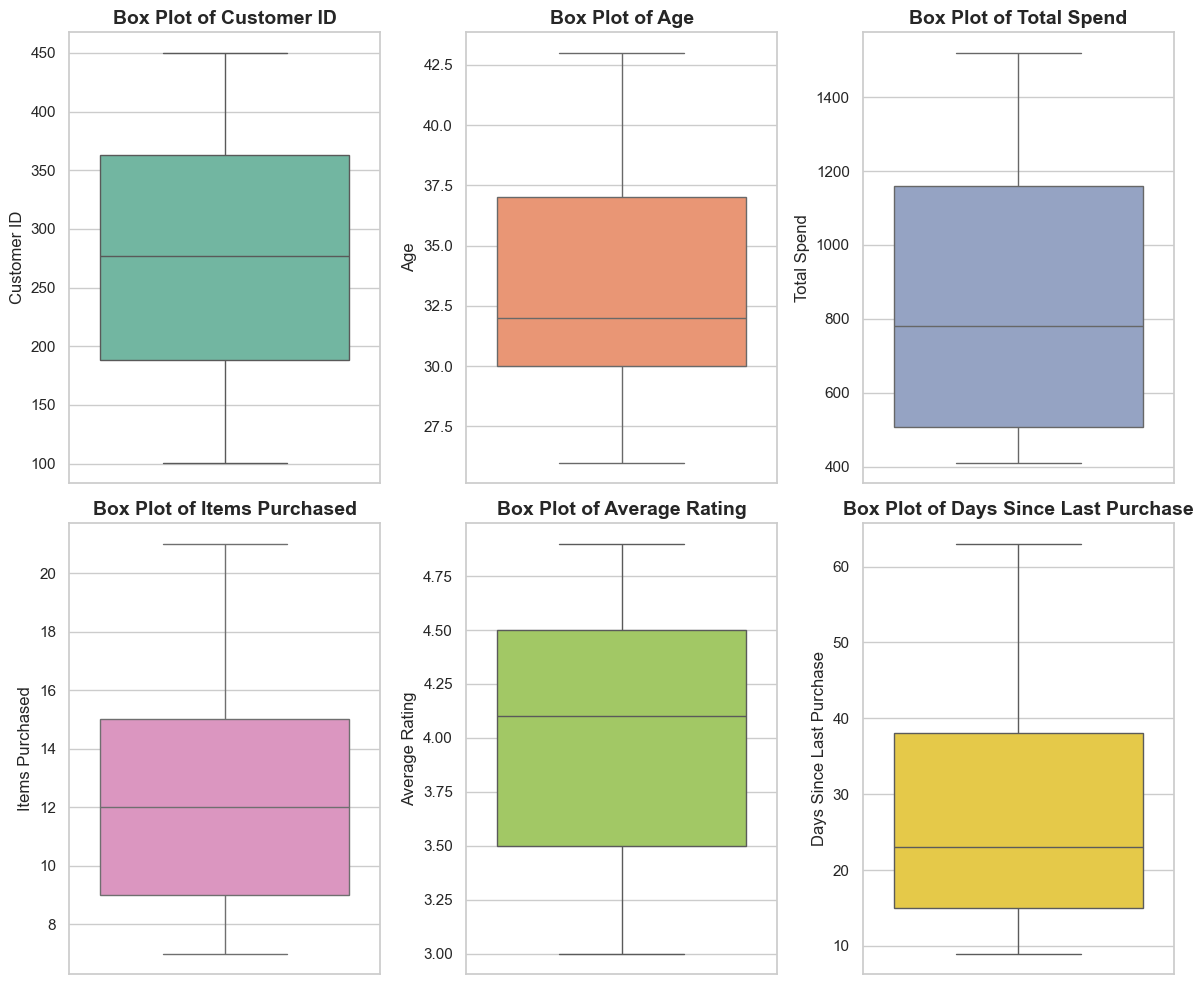

In [56]:
numeric_columns = data_full.select_dtypes(include=['number']).columns

# Create a 2x2 grid for the pie charts
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Flatten the axes array for iter
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Plot box plot on the corresponding axis
    sns.boxplot(y=data_full[col], ax=axes[i], color=sns.color_palette("Set2")[i])
    
    # Set the title for each subplot
    axes[i].set_title(f'Box Plot of {col}', fontsize=14, fontweight='bold')

# Adjust layout, prevent overlap
plt.tight_layout()

plt.show()

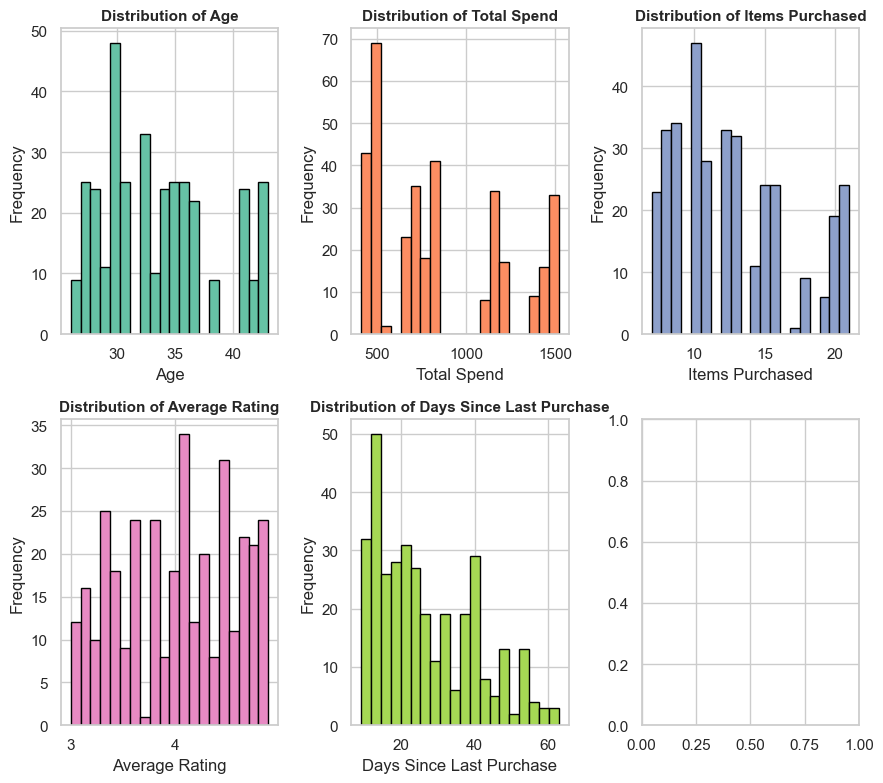

In [57]:
numeric_columns = [col for col in numeric_columns if col != "Customer ID"]

# Create a 2x2 grid for the histogram
fig, axes = plt.subplots(2, 3, figsize=(9, 8))

# Flatten the axes array for iter
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Plot histogram on the corresponding axis
    axes[i].hist(data_full[col], bins=20, color=sns.color_palette("Set2")[i], edgecolor='black')
    
    # Set the title for each subplot
    axes[i].set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
    
    # Set labels
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Adjust layout, prevent overlap
plt.tight_layout()

plt.show()

# Cleaning the data

While the data is cleaned (in the proper structure), we will need to one-hot encode the cat vars for modelling

In [58]:
from sklearn.preprocessing import LabelEncoder

data_encoded = data_full.copy()
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Initialize a dictionary to store the encoders
label_encoders = {}

# Apply label encoding to each categorical column
for col in data_encoded.select_dtypes(include=['object', 'category']).columns:
    data_encoded[col] = label_encoder.fit_transform(data_encoded[col])
    
    # Save the encoder mapping
    label_encoders[col] = {class_label: int(value) for class_label, value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

    print(f"Encoded {col}: {label_encoders[col]}")

# reverse_mapping = {v: k for k, v in label_encoders[''].items()}
data_encoded.head()

# saving the encoded data
data_encoded.to_csv('data/data_encoded.csv')


Encoded Gender: {'Female': 0, 'Male': 1}
Encoded City: {'Chicago': 0, 'Houston': 1, 'Los Angeles': 2, 'Miami': 3, 'New York': 4, 'San Francisco': 5}
Encoded Membership Type: {'Bronze': 0, 'Gold': 1, 'Silver': 2}
Encoded Satisfaction Level: {'Neutral': 0, 'Satisfied': 1, 'Unsatisfied': 2}


Now, we will normalise the numerical values in order to ensure equal contribution

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_normal = data_encoded.copy()
colnames = data_encoded.columns

data_normal[numeric_columns] = scaler.fit_transform(data_normal[numeric_columns])

data_normal.head()

data_normal.to_csv('data/data_normal.csv')